In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = "../data/dataset"

In [4]:
#LOAD DATA menggunakan TensorFlow (bukan PyTorch lagi)
# Langsung load dengan TensorFlow ImageDataGenerator atau image_dataset_from_directory
img_height = 224
img_width = 224
batch_size = 32

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print("Kelas:", train_ds.class_names)
print("Train batches:", len(train_ds))
print("Val batches:", len(val_ds))

Found 907 files belonging to 6 classes.
Using 726 files for training.
Found 907 files belonging to 6 classes.
Using 181 files for validation.
Kelas: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']
Train batches: 23
Val batches: 6


In [5]:
class_names = train_ds.class_names
print (class_names)

['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


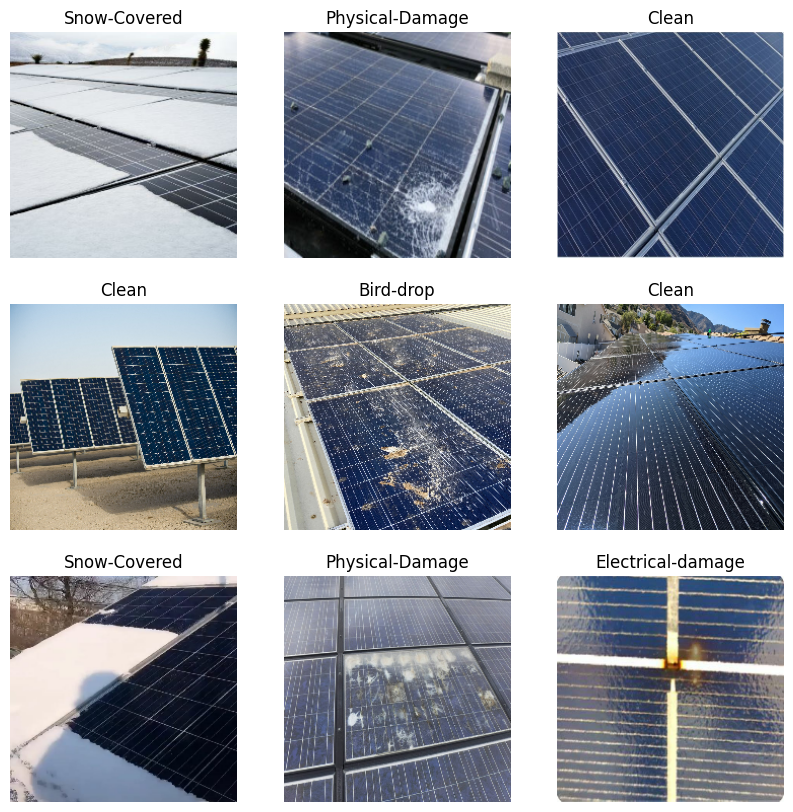

In [6]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range (9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
import os
import shutil
import random
from pathlib import Path

# Setup paths
BASE_DIR = Path("../data")
SOURCE_DATASET = BASE_DIR / "dataset"  # Lokasi data asli
YOLO_DATASET = BASE_DIR / "yolo_dataset"  # Output YOLO format

# Class mapping
CLASSES = ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']
class_to_id = {cls: idx for idx, cls in enumerate(CLASSES)}

# Split ratio
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1

print("🚀 Starting dataset preparation (ini agak lama, sabar ya ~2-3 menit)...")
print(f"Source: {SOURCE_DATASET}")
print(f"Destination: {YOLO_DATASET}\n")

# Create YOLO directory structure
for split in ['train', 'val', 'test']:
    (YOLO_DATASET / 'images' / split).mkdir(parents=True, exist_ok=True)
    (YOLO_DATASET / 'labels' / split).mkdir(parents=True, exist_ok=True)

# Process setiap class
for class_name in CLASSES:
    class_dir = SOURCE_DATASET / class_name
    
    if not class_dir.exists():
        print(f"⚠️  Folder {class_name} tidak ditemukan")
        continue
    
    # Get semua images
    images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
    if not images:
        print(f"⚠️  No images in {class_name}")
        continue
        
    random.shuffle(images)
    
    # Split data
    total = len(images)
    train_count = int(total * TRAIN_RATIO)
    val_count = int(total * VAL_RATIO)
    
    train_imgs = images[:train_count]
    val_imgs = images[train_count:train_count + val_count]
    test_imgs = images[train_count + val_count:]
    
    print(f"📦 {class_name}: {total} → train:{len(train_imgs)} val:{len(val_imgs)} test:{len(test_imgs)}", end="")
    
    # Copy files + generate dummy labels
    class_id = class_to_id[class_name]
    
    for split_name, img_list in [('train', train_imgs), ('val', val_imgs), ('test', test_imgs)]:
        for img_path in img_list:
            # Copy image
            dst_img = YOLO_DATASET / 'images' / split_name / img_path.name
            shutil.copy2(img_path, dst_img)
            
            # Generate dummy label (full-frame bbox)
            label_name = img_path.stem + '.txt'
            label_path = YOLO_DATASET / 'labels' / split_name / label_name
            
            with open(label_path, 'w') as f:
                f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")
    
    print(" ✓")

print(f"\n✅ Dataset YOLO siap di: {YOLO_DATASET}")
print(f"📁 Structure created successfully")

: 

In [ ]:
# Create YOLO dataset.yaml config
from pathlib import Path

BASE_DIR = Path("../data")

yaml_content = """path: ../data/yolo_dataset  # dataset root
train: images/train
val: images/val
test: images/test

nc: 6  # number of classes
names: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']
"""

yaml_path = BASE_DIR / 'yolo_dataset' / 'data.yaml'
yaml_path.parent.mkdir(parents=True, exist_ok=True)
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"✅ Config YOLO dibuat: {yaml_path}")
print(yaml_content)

✅ Config YOLO dibuat: ..\data\yolo_dataset\data.yaml
path: ../data/yolo_dataset  # dataset root
train: images/train
val: images/val
test: images/test

nc: 6  # number of classes
names: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']



In [ ]:
# Install ultralytics (YOLO)
import subprocess
import sys

print("📦 Installing ultralytics...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "ultralytics"])
print("✅ ultralytics installed!")

📦 Installing ultralytics...


In [ ]:
from ultralytics import YOLO
import yaml

# Verify YOLO installation
print("🚀 YOLO imported successfully!")

# Load config path
yaml_file = str(BASE_DIR / 'yolo_dataset' / 'data.yaml')
print(f"📋 Dataset config: {yaml_file}")

# Verify yaml exists
with open(yaml_file, 'r') as f:
    config = yaml.safe_load(f)
    print(f"✅ Config loaded: {config['names']}")

In [ ]:
# Initialize YOLO model
# Models: yolov10n, yolov10s, yolov10m, yolov10b, yolov10l, yolov10x
model = YOLO('yolov10s.pt')  # Small model (fast, good balance)
print("✅ YOLOv10s model loaded")

In [ ]:
# Training configuration
EPOCHS = 50
IMG_SIZE = 640  # YOLO standard size
BATCH_SIZE = 16  # Adjust based on GPU VRAM
DEVICE = 0  # GPU device index (0 = first GPU, 'cpu' = CPU only)

print(f"""
🎯 Training Configuration:
   - Epochs: {EPOCHS}
   - Image Size: {IMG_SIZE}
   - Batch Size: {BATCH_SIZE}
   - Device: {DEVICE}
   - Dataset: {yaml_file}
""")

In [ ]:
# Train YOLO model
# Note: Jika muncul error memory, turunkan BATCH_SIZE atau IMG_SIZE
print("🚀 Starting training...")

results = model.train(
    data=yaml_file,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    device=DEVICE,
    patience=10,  # Early stopping
    save=True,
    project='../models',  # Save path
    name='yolo_solar_detector',
    pretrained=True,
    augment=True,
    verbose=True,
)

print("\n✅ Training selesai!")

In [ ]:
# Visualisasi metrik training dari results.csv
# Plot loss (box/cls/dfl) dan mAP jika tersedia
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

results_path = Path('../models/yolo_solar_detector')
results_csv = results_path / 'results.csv'

if not results_csv.exists():
    print(f'⚠️  results.csv tidak ditemukan di {results_csv}')
else:
    df = pd.read_csv(results_csv)
    epochs = df['epoch'] if 'epoch' in df.columns else range(len(df))

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # --- Plot Loss ---
    loss_cols = [c for c in ['train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss'] if c in df.columns]
    if loss_cols:
        for c in loss_cols:
            axes[0].plot(epochs, df[c], label=c)
        axes[0].set_title('Loss per Epoch')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()
    else:
        axes[0].text(0.5, 0.5, 'Loss columns not found', ha='center')

    # --- Plot mAP/metrics ---
    metric_cols = [c for c in ['metrics/mAP50', 'metrics/mAP50-95', 'metrics/precision', 'metrics/recall'] if c in df.columns]
    if metric_cols:
        for c in metric_cols:
            axes[1].plot(epochs, df[c], label=c)
        axes[1].set_title('Metrics per Epoch')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Score')
        axes[1].grid(True, alpha=0.3)
        axes[1].legend()
    else:
        axes[1].text(0.5, 0.5, 'Metric columns not found', ha='center')

    plt.tight_layout()
    plt.show()


In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Path ke folder hasil training (sama seperti konfigurasi model.train)
results_path = Path('../models/yolo_solar_detector')
results_csv = results_path / 'results.csv'

if not results_csv.exists():
    print(f'⚠️  results.csv tidak ditemukan di {results_csv}')
else:
    df = pd.read_csv(results_csv)
    print(f'✅ Loaded results.csv, total epochs logged: {len(df)}')
    display(df.head())
    # Cari epoch terbaik (mAP50-95 jika ada, else mAP50)
    best_metric_col = 'metrics/mAP50-95' if 'metrics/mAP50-95' in df.columns else ('metrics/mAP50' if 'metrics/mAP50' in df.columns else None)
    if best_metric_col:
        best_idx = df[best_metric_col].idxmax()
        best_row = df.loc[best_idx]
        print(f"Best epoch: {int(best_row['epoch'])} | {best_metric_col} = {best_row[best_metric_col]:.4f}")


In [ ]:
# Visualize training results
from pathlib import Path

results_path = Path('../models/yolo_solar_detector')
print(f"📊 Training results saved di: {results_path}")

# Plot training curves
if (results_path / 'results.png').exists():
    from PIL import Image
    img = Image.open(results_path / 'results.png')
    plt.figure(figsize=(15, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Training Results')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  results.png tidak ditemukan")

In [ ]:
# Evaluate on test set
print("📊 Evaluating on test set...")

best_model_path = results_path / 'weights' / 'best.pt'
best_model = YOLO(str(best_model_path))

# Metrics
metrics = best_model.val(data=yaml_file, device=DEVICE)

print(f"\n✅ Evaluation Metrics:")
print(f"   mAP50: {metrics.box.map50:.4f}")
print(f"   mAP50-95: {metrics.box.map:.4f}")

In [ ]:
# Test inference on single image
from PIL import Image
import cv2

# Test dengan gambar dari training set
test_img_dir = BASE_DIR / 'yolo_dataset' / 'images' / 'test'
test_images = list(test_img_dir.glob('*.jpg')) + list(test_img_dir.glob('*.png'))

if test_images:
    test_image = str(test_images[0])
    
    print(f"🖼️  Testing inference on: {Path(test_image).name}")
    
    # Run inference
    results = best_model.predict(source=test_image, conf=0.5, device=DEVICE)
    
    # Display result
    result = results[0]
    if result.boxes:
        print(f"✅ Detected {len(result.boxes)} object(s)")
        for box in result.boxes:
            cls_name = CLASSES[int(box.cls[0])]
            conf = box.conf[0]
            print(f"   - {cls_name}: {conf:.2%}")
    else:
        print("⚠️  No objects detected")
    
    # Show image with detections
    result_img = result.plot()
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Inference: {Path(test_image).name}")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No test images found")

In [ ]:
# Batch inference on test folder
print("🎯 Running batch inference on test set...")

test_dir = str(BASE_DIR / 'yolo_dataset' / 'images' / 'test')
results_batch = best_model.predict(source=test_dir, conf=0.5, device=DEVICE, save=True)

print(f"✅ Batch inference selesai!")
print(f"📊 Predictions saved ke: {best_model.predict.__self__.results_dir if hasattr(best_model.predict, '__self__') else 'runs/detect'}")

# Summary statistics
total_detections = 0
class_counts = {cls: 0 for cls in CLASSES}

for result in results_batch:
    total_detections += len(result.boxes)
    for box in result.boxes:
        cls_id = int(box.cls[0])
        class_counts[CLASSES[cls_id]] += 1

print(f"\n📈 Detection Summary:")
print(f"   Total detections: {total_detections}")
for cls, count in class_counts.items():
    print(f"   - {cls}: {count}")

In [ ]:
# Save final model
print("💾 Saving final model...")

model_save_path = Path('../models/best_model.pt')
model_save_path.parent.mkdir(parents=True, exist_ok=True)

import shutil
best_pt = results_path / 'weights' / 'best.pt'
if best_pt.exists():
    shutil.copy(best_pt, model_save_path)
    print(f"✅ Model saved ke: {model_save_path}")
else:
    print("⚠️  best.pt tidak ditemukan")

# Create inference script template
inference_script = '''
from ultralytics import YOLO
from pathlib import Path

# Load model
model = YOLO("../models/best_model.pt")

# Inference on image/folder/video
results = model.predict(source="path/to/image.jpg", conf=0.5)

# Visualize
for result in results:
    result.show()
'''

script_path = Path('../inference_template.py')
with open(script_path, 'w') as f:
    f.write(inference_script)

print(f"\n✅ Inference template dibuat: {script_path}")
print(f"\n📋 Pipeline Summary:")
print(f"   ✓ Data prepared & split (train/val/test)")
print(f"   ✓ YOLO model trained")
print(f"   ✓ Model evaluated")
print(f"   ✓ Batch inference completed")
print(f"   ✓ Best model saved")
print(f"\n🎉 YOLO training pipeline selesai!")